# Attractor Comparisons
Probe the 'depth' and density of attractors

Feb 20, 2018 


Jan 10, 2019 UPDATE: The data can be collected on Odyssey and then subsequently analyzed here... 
For clarity, the data generation code has been moved up toward the top of this script and the rest of the notebook used for analysis space

Sam Goldman



In [3]:
import sys
import os
sys.path.append("../Classes")
from HomGraph import *
from SFGraph import *
from sighelp import *

from AttractorGraph import * 
from matplotlib.pyplot import cm
from matplotlib.mlab import frange
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from scipy import sparse
import scipy as scp
from scipy.sparse import csgraph

# import networkx as nx 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from functools import reduce

from matplotlib import rcParams

import pickle 



from matplotlib import rcParams
sns.set(context='paper',font_scale = 7,
        rc = {'figure.figsize' : (20,10), 'legend.frameon':True, 
              'legend.loc': 'upper right', "xtick.major.size": 10,"ytick.major.size": 10,
             "xtick.minor.size": 6,"ytick.minor.size": 6, 
              "xtick.major.width": 3, "ytick.major.width": 3,
             "xtick.minor.width": 1, "ytick.minor.width": 1})

# sns.set_style("white")
sns.set_style("ticks")



# Code for data generation

Note, separately this is now done in a script and on Odyssey

Using oscillations nad a central hub node

In [26]:

n = 1000
## If homogeneous,  
## n = 50 
## ks = np.arange(1,12)

num_trials = 1000
periods = np.array([4,30])#np.arange(2, 40, 8)

gammas = np.array([1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 3.0])  #np.linspace(1.7, 3.0, 12)
num_networks = 10
hub_rank = 0 
t = 1000
results_dict = {}
outfile = "/Users/Sam/Desktop/results_dict.p"


In [ ]:
for gamma in gammas: 
    results_dict[gamma] = {}
    results_dict[gamma]['hub_out'] = [] 
    results_dict[gamma]['blocked_ctrl'] = {'avg_size': [], 'avg_number': []}
    results_dict[gamma]['free_ctrl'] = {'avg_size': [], 'avg_number': []}
    for per in periods: 
        results_dict[gamma][str(per)] = {'avg_depth': [], 'avg_number': [], 'avg_size': []}

failed_nets = {gamma: 0 for gamma in gammas} 
for gamma in gammas: 
    print(gamma)
    if gamma < 1.8:
        t = 8000
    elif gamma < 2.0: 
        t = 2000 
    else: 
        t = 1000
    for network_num in range(num_networks):
        print(network_num)
        my_graph = SFGraph(n, gamma)
        oscil_node = my_graph.find_hub(hub_rank)        
        test_graph = AttractorGraph(graph=my_graph, oscil_node=oscil_node)
        
        avg_depth_temp = {} 
        
        # Check base.. 
        # wrap the whole thing in a try catch so if this network bombs, we just go to next
        try:
            for _ in range(num_trials):
                test_graph.graph.random_config()
                test_graph.explore_state_block(block_nodes=oscil_node, block_state=test_graph.graph.get_config()[oscil_node], t=t)
                test_graph.graph.random_config()
                test_graph.explore_state_free(t=t)

            test_graph.explore_periods(periods, num_trials, t=t, explore_null = False)
            
            
            num_block_ctrl_attractors = len(test_graph.per_map['0'].keys())
            num_free_ctrl_attractors = len(test_graph.per_map['-1'].keys())
            avg_block_ctrl_attractor_size = test_graph.get_avg_attractor_size('0')
            avg_free_ctrl_attractor_size = test_graph.get_avg_attractor_size('-1')

            
            for per in periods:
                avg_depth_temp[per] = test_graph.avg_depth_period(per=str(per), t= t)


        except Exception as e: 
            failed_nets[gamma]+=1
            print(e, f"no attr found for gamma {gamma}, network number failed: ", failed_nets[gamma])
            continue
            
        results_dict[gamma]['hub_out'].append(my_graph.out_degree()[oscil_node])
        
        results_dict[gamma]['blocked_ctrl']['avg_number'].append(num_block_ctrl_attractors)
        results_dict[gamma]['blocked_ctrl']['avg_size'].append(avg_block_ctrl_attractor_size)
        results_dict[gamma]['free_ctrl']['avg_number'].append(num_free_ctrl_attractors)
        results_dict[gamma]['free_ctrl']['avg_size'].append(avg_free_ctrl_attractor_size)
        
        for per in periods: 
            results_dict[gamma][str(per)]['avg_number'].append(len(test_graph.per_map[str(per)].keys()))
            results_dict[gamma][str(per)]['avg_depth'].append(avg_depth_temp[per])
            results_dict[gamma][str(per)]['avg_size'].append(test_graph.get_avg_attractor_size(per))


            

In [ ]:
with open(outfile, "wb") as fp: 
    pickle.dump(results_dict, fp)

# Analysis

## Pre-odyssey analysis

### Oscillations

In [3]:
with open("../../Results/Oscillating/Oscillating Attractors/Quantitative/N1000/NEWDISTresults_dict.p", "rb") as fp:
    results_dict = pickle.load(fp)

In [4]:
results_dict
gammas = list(results_dict.keys())
periods = [i for i in results_dict[gammas[0]].keys() if i.isdigit()]
print(periods)

['2', '10', '18', '26', '34']


In [5]:
def pretty_print_results(r):
    for gamma in r.keys():
        print("Gamma: ", gamma)
        print("\tAvg outdegree of hub: ", np.mean(r[gamma]['hub_out']))
        print("\tAvg number of attrs for blocked hub: ", np.mean(r[gamma]['blocked_ctrl']))
        print("\tAvg number of attrs for free updating hub: ", np.mean(r[gamma]['free_ctrl']))
        for per in periods: 
            print("\tPERIOD: ", per)
            print("\t\tAvg Depth: ", np.mean(r[gamma][str(per)]['avg_depth']))
            print("\t\tAvg number: ", np.mean(r[gamma][str(per)]['avg_number']))

pretty_print_results(results_dict)


Gamma:  1.7
	Avg outdegree of hub:  799.4
	Avg number of attrs for blocked hub:  14.6
	Avg number of attrs for free updating hub:  6.4
	PERIOD:  2
		Avg Depth:  47.6528801843318
		Avg number:  2.4
	PERIOD:  10
		Avg Depth:  25.79583333333333
		Avg number:  1.4
	PERIOD:  18
		Avg Depth:  21.541666666666664
		Avg number:  1.4
	PERIOD:  26
		Avg Depth:  29.78846153846154
		Avg number:  1.0
	PERIOD:  34
		Avg Depth:  21.76402944690421
		Avg number:  1.4
Gamma:  1.8181818181818181
	Avg outdegree of hub:  686.2
	Avg number of attrs for blocked hub:  49.6
	Avg number of attrs for free updating hub:  32.8
	PERIOD:  2
		Avg Depth:  21.69351724664225
		Avg number:  13.0
	PERIOD:  10
		Avg Depth:  21.511785714285715
		Avg number:  8.4
	PERIOD:  18
		Avg Depth:  16.598946643646975
		Avg number:  8.4
	PERIOD:  26
		Avg Depth:  14.45158037489909
		Avg number:  7.2
	PERIOD:  34
		Avg Depth:  18.312315658772302
		Avg number:  8.0
Gamma:  1.9363636363636363
	Avg outdegree of hub:  474.4
	Avg number of 

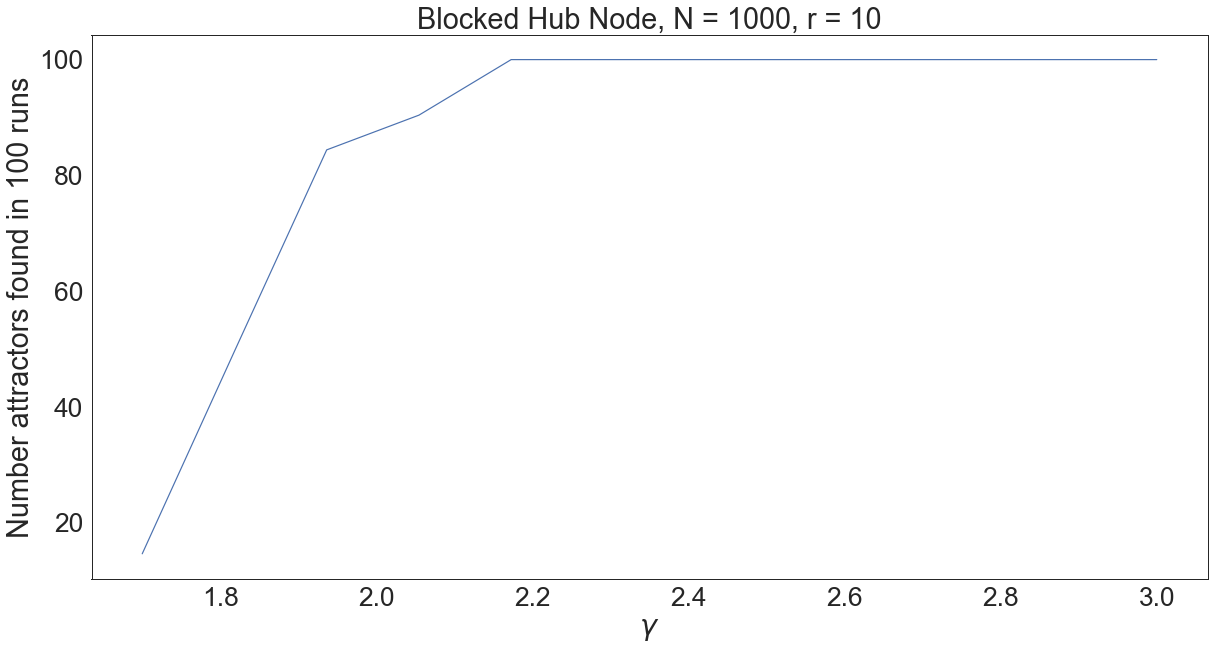

In [16]:
# gammas 
plt.plot(gammas, [np.mean(results_dict[gam]['blocked_ctrl']) for gam in gammas])
plt.xlabel(r"$\gamma$")
plt.ylabel("Number attractors found in 100 runs")
plt.title("Blocked Hub Node, N = 1000, r = 10")
plt.show()


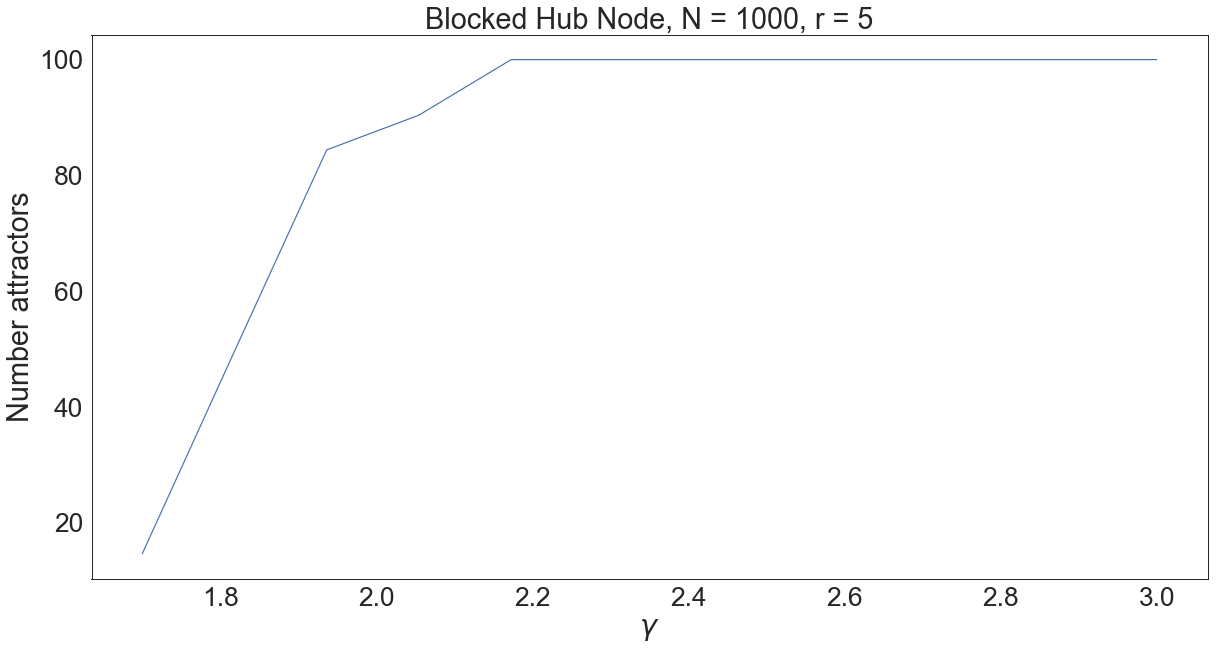

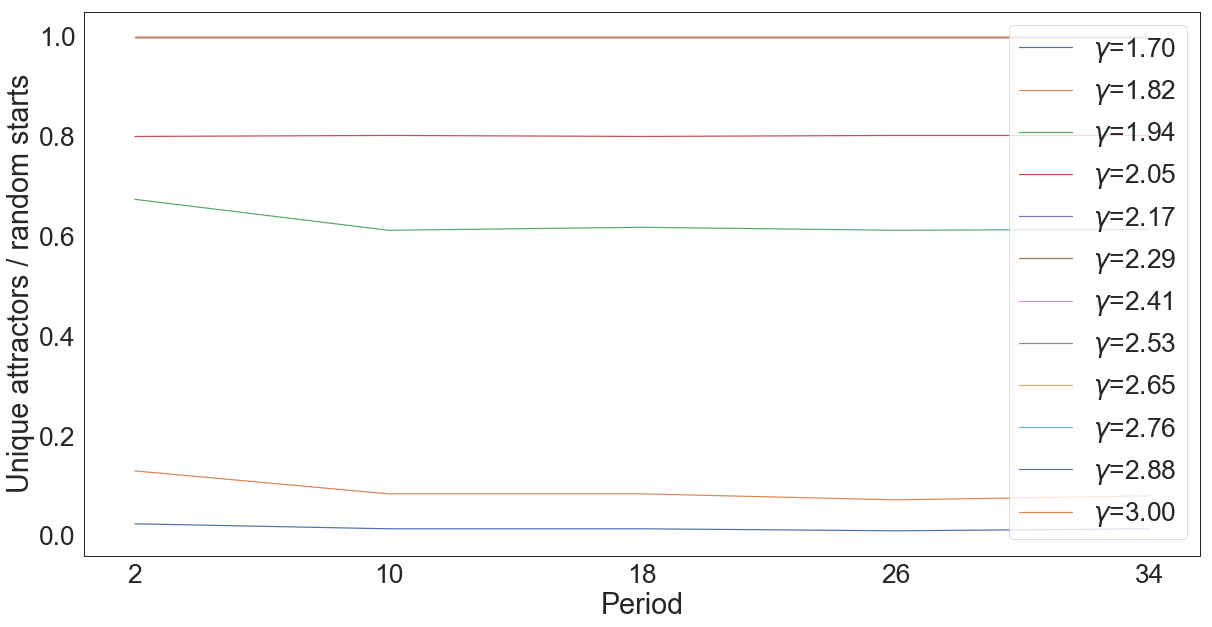

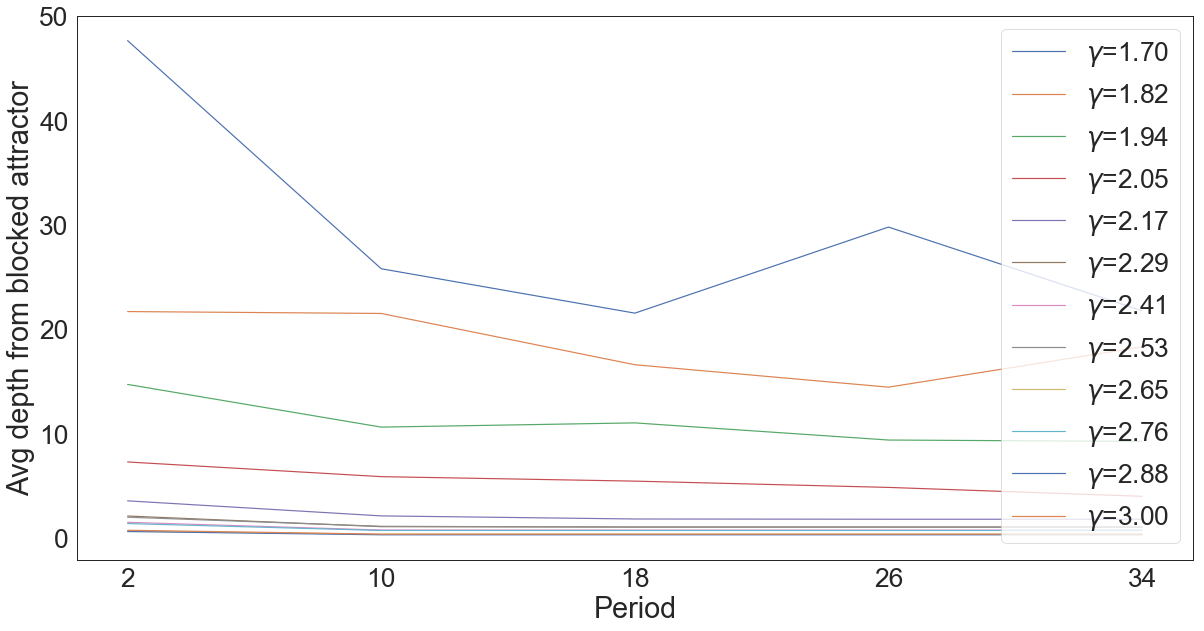

In [15]:
# gammas 
plt.plot(gammas, [np.mean(results_dict[gam]['blocked_ctrl']) for gam in gammas])
plt.xlabel(r"$\gamma$")
plt.ylabel("Number attractors")
plt.title("Blocked Hub Node, N = 1000, r = 5")
plt.show()

for gamma in results_dict.keys():
    plt.plot(periods, [np.mean(results_dict[gamma][str(per)]['avg_number']) / 100.0 
                       for per in periods], label=r"$\gamma$=%.2f" %gamma)
   
plt.xlabel("Period")
plt.ylabel("Unique attractors / random starts")
# plt.title("Num attractors by period")
plt.legend()
plt.show()


for gamma in results_dict.keys():
    plt.plot(periods, [np.mean(results_dict[gamma][str(per)]['avg_depth']) 
                       for per in periods], label=r"$\gamma$=%.2f" %gamma)
   
plt.xlabel("Period")
plt.ylabel("Avg depth from blocked attractor")
# plt.title("Depth attractors by period")
plt.legend()
plt.show()




In [6]:

df = []
for gamma in results_dict: 
    for key in results_dict[gamma]:
        if key.isdigit():
            df.append({"$\gamma$":np.round(gamma,2), "T": int(key), 
             "Average Depth": np.mean(results_dict[gamma][key]['avg_depth']),
            "Average Number": 
             np.mean(results_dict[gamma][key]['avg_number']) / 100.0})            
df = pd.DataFrame(df)
df = df.sort_values(["$\gamma$", "T"])#.reset_index(drop=True)
df

,$\gamma$,Average Depth,Average Number,T
0,1.70,47.652880,0.024,2
1,1.70,25.795833,0.014,10
2,1.70,21.541667,0.014,18
3,1.70,29.788462,0.010,26
4,1.70,21.764029,0.014,34
5,1.82,21.693517,0.130,2
6,1.82,21.511786,0.084,10
7,1.82,16.598947,0.084,18
8,1.82,14.451580,0.072,26
9,1.82,18.312316,0.080,34


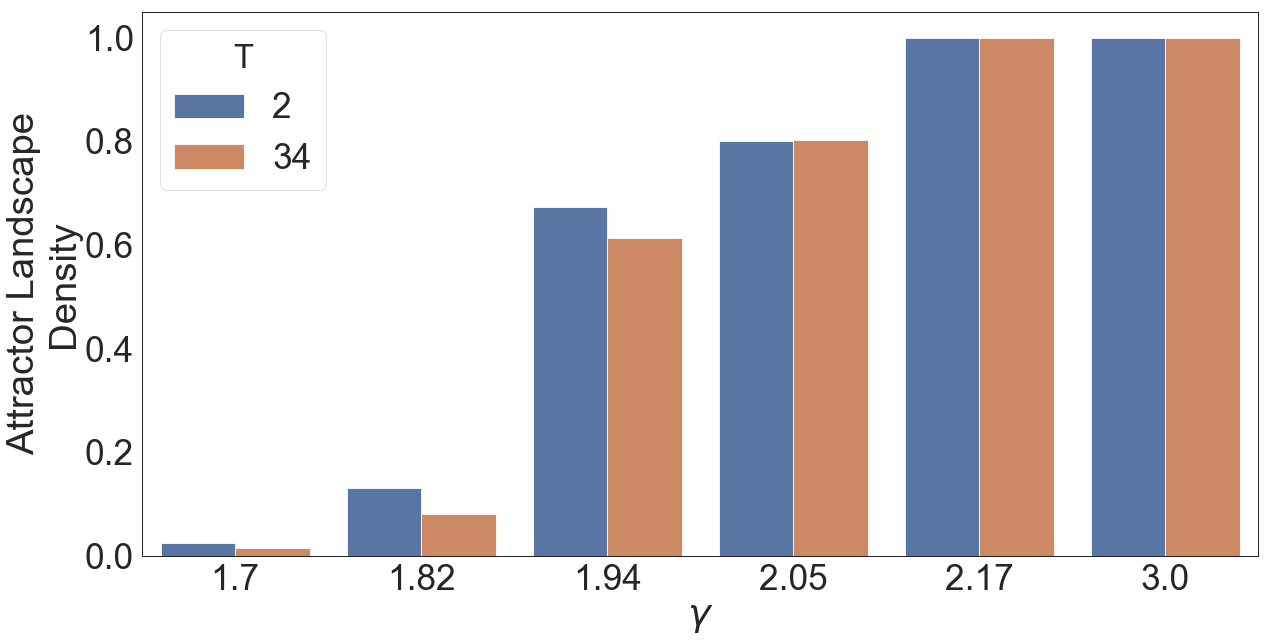

In [16]:

# Turn this into a barplot... 
indices = np.logical_or(df["$\gamma$"] < 2.2, df["$\gamma$"] >2.9)
indices_2 = np.logical_and(indices, np.logical_or(df["T"] == 2, df["T"] == 34))


sns.barplot(x ="$\gamma$", hue="T",y="Average Number", data=df[indices_2])
plt.ylabel("Attractor Landscape\nDensity")
plt.show()

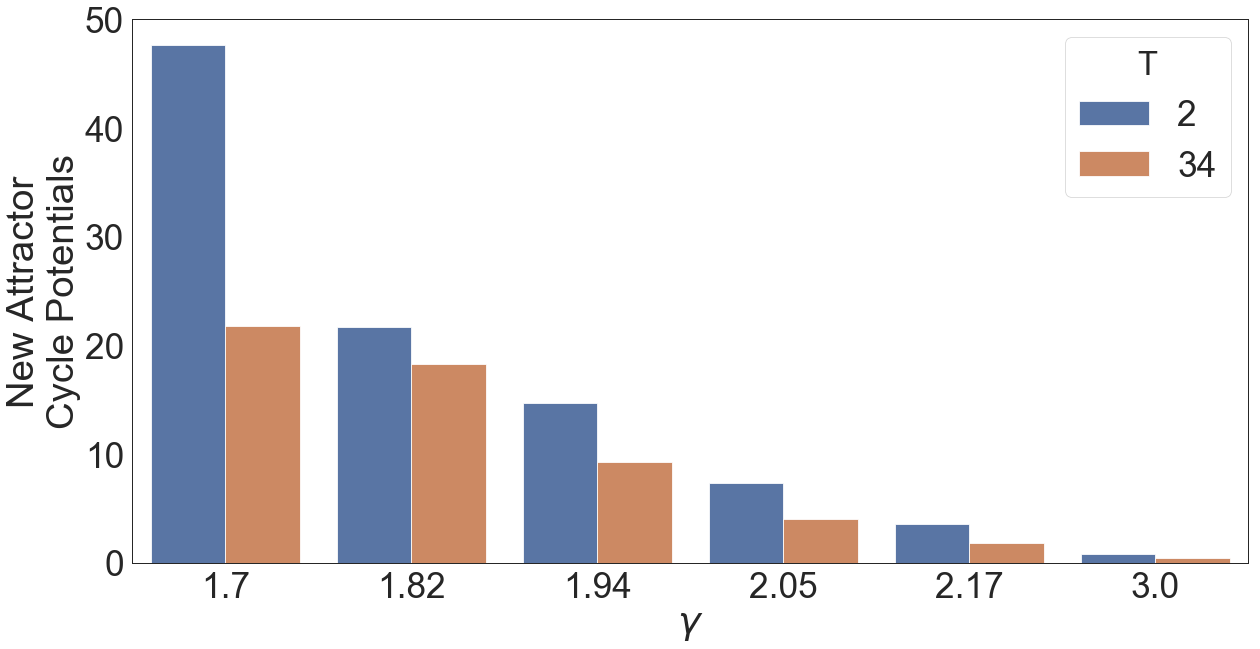

In [11]:
# Turn this into a barplot... 
indices = np.logical_or(df["$\gamma$"] < 2.2, df["$\gamma$"] >2.9)
indices_2 = np.logical_or(df["T"] == 2, df["T"] == 34)


indices = np.logical_and(indices, indices_2)


sns.barplot(x ="$\gamma$", hue="T",y="Average Depth", data=df[indices ])
plt.ylabel("New Attractor\nCycle Potentials")
plt.show()

### Repeat this with homogeneous networks!

In [7]:
pretty_print_results(results_dict)

Gamma:  1
	Avg outdegree of hub:  4.0
	Avg number of attrs for blocked hub:  100.0
	Avg number of attrs for free updating hub:  100.0
	PERIOD:  2
		Avg Depth:  0.028000000000000004
		Avg number:  100.0
	PERIOD:  10
		Avg Depth:  0.014000000000000002
		Avg number:  100.0
	PERIOD:  18
		Avg Depth:  0.014000000000000002
		Avg number:  100.0
	PERIOD:  26
		Avg Depth:  0.014000000000000002
		Avg number:  100.0
	PERIOD:  34
		Avg Depth:  0.014000000000000002
		Avg number:  100.0
Gamma:  2
	Avg outdegree of hub:  6.4
	Avg number of attrs for blocked hub:  99.8
	Avg number of attrs for free updating hub:  99.8
	PERIOD:  2
		Avg Depth:  0.17114300903774587
		Avg number:  98.8
	PERIOD:  10
		Avg Depth:  0.08337639553429027
		Avg number:  99.0
	PERIOD:  18
		Avg Depth:  0.08181624515835041
		Avg number:  99.0
	PERIOD:  26
		Avg Depth:  0.08274481658692183
		Avg number:  99.0
	PERIOD:  34
		Avg Depth:  0.08274481658692183
		Avg number:  99.0
Gamma:  3
	Avg outdegree of hub:  6.6
	Avg number of att

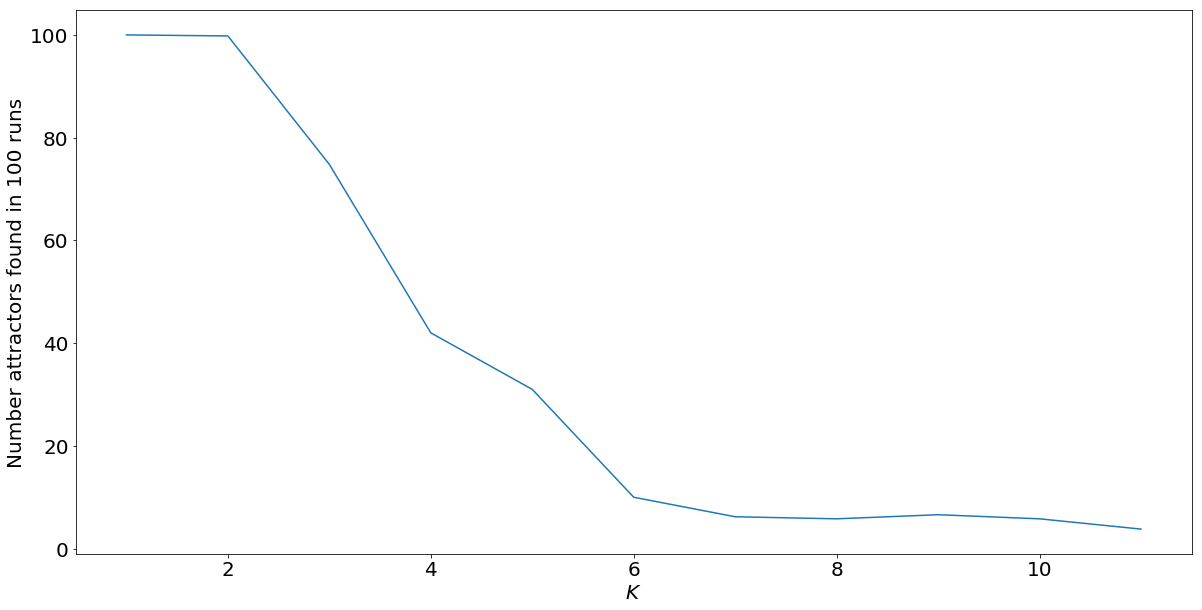

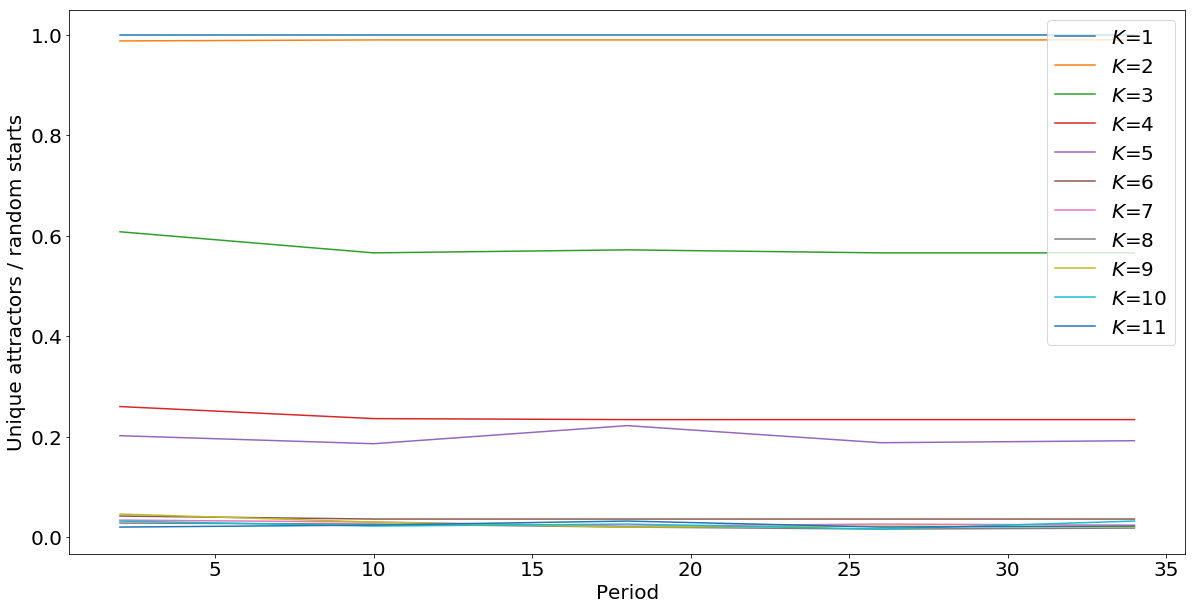

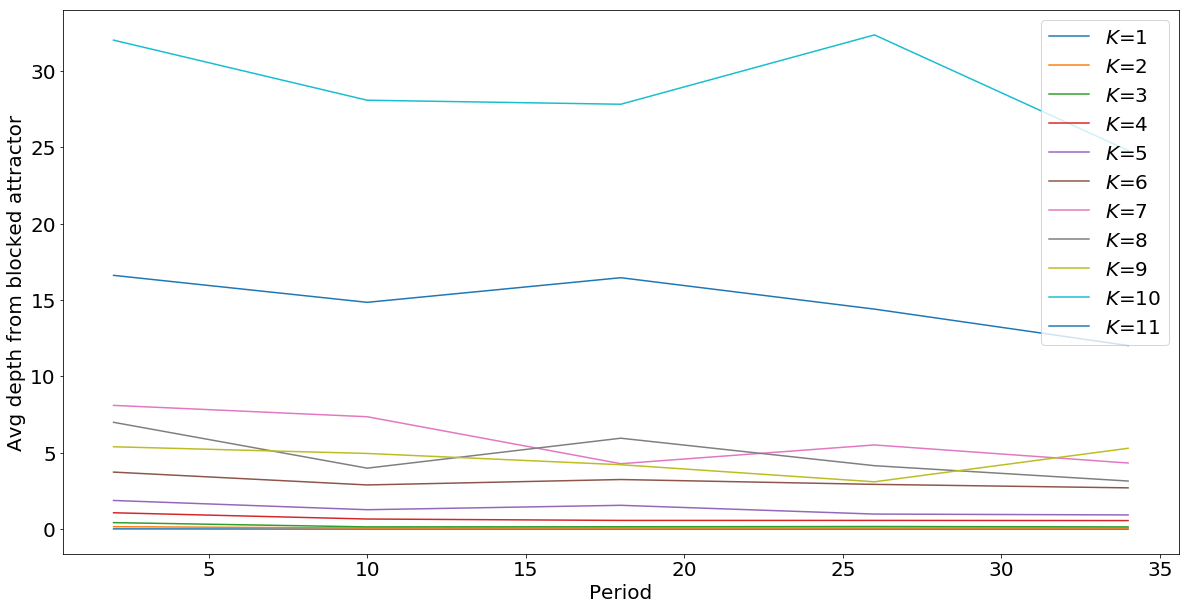

In [12]:
# gammas 
plt.plot(ks, [np.mean(results_dict[gam]['blocked_ctrl']) for gam in ks])
plt.xlabel(r"$K$")
plt.ylabel("Number attractors found in 100 runs")
# plt.title("Blocked Hub Node, N = 50, r = 5")
plt.show()

for gamma in results_dict.keys():
    plt.plot(periods, [np.mean(results_dict[gamma][str(per)]['avg_number']) / 100.0 
                       for per in periods], label=r"$K$=%d" %gamma)
   
plt.xlabel("Period")
plt.ylabel("Unique attractors / random starts")
# plt.title("Num attractors by period")
plt.legend()
plt.show()


for gamma in results_dict.keys():
    plt.plot(periods, [np.mean(results_dict[gamma][str(per)]['avg_depth']) 
                       for per in periods], label=r"$K$=%d" %gamma)
   
plt.xlabel("Period")
plt.ylabel("Avg depth from blocked attractor")
# plt.title("Depth attractors by period")
plt.legend()
plt.show()





### Moving hub node

In [10]:
import pickle 
with open("/Users/Sam/Desktop/results_dict_100th_hub_node.p", "wb") as fp: 
    pickle.dump(results_dict, fp)

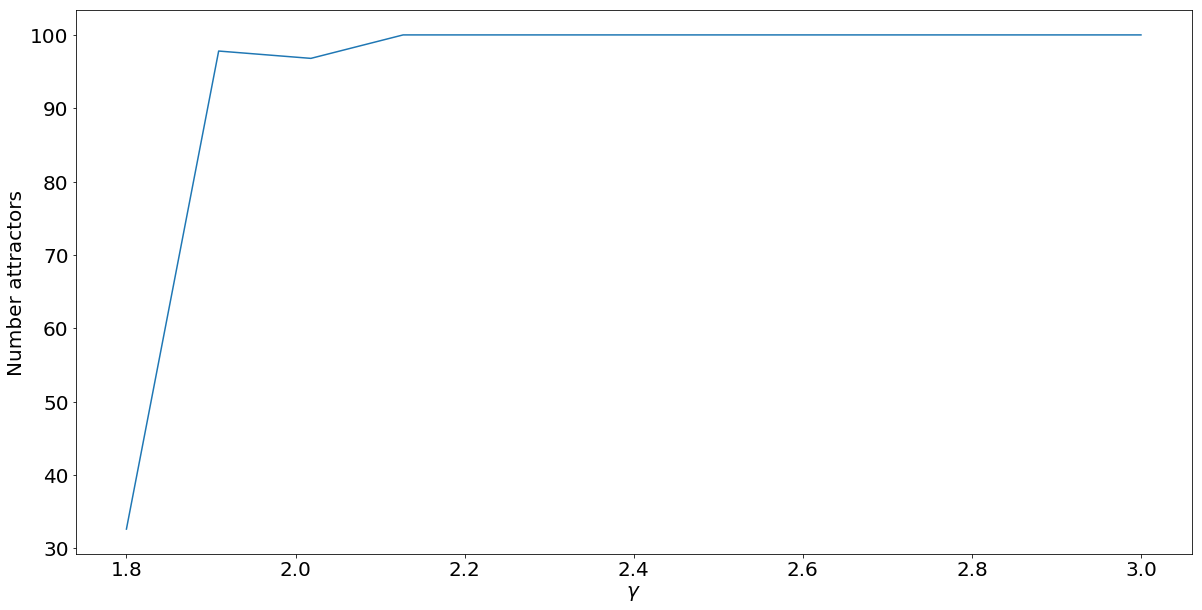

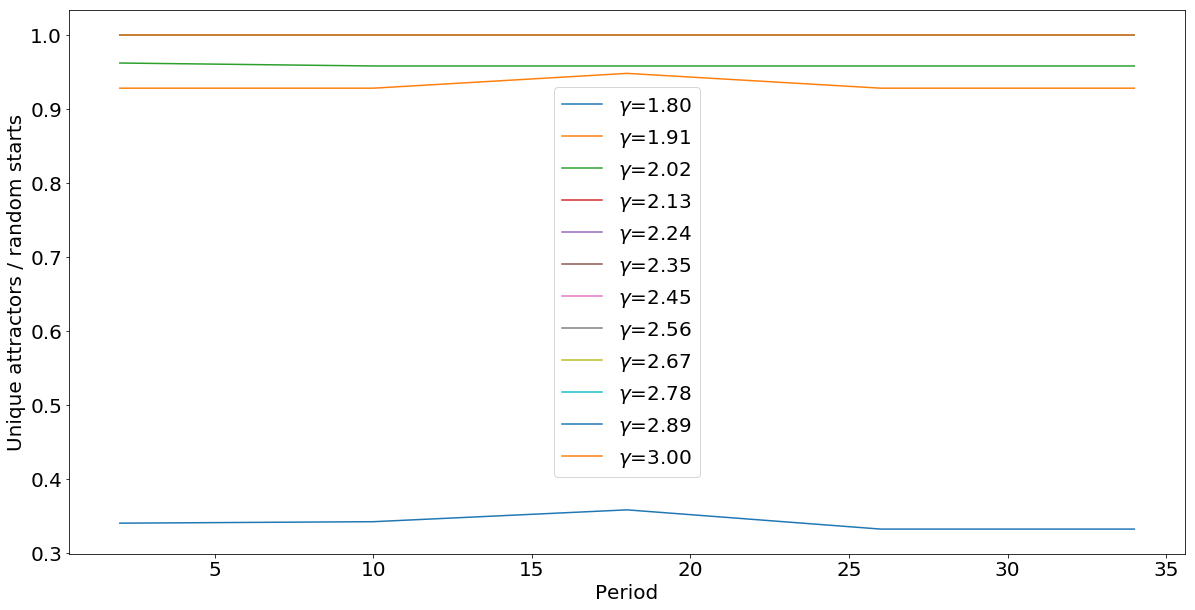

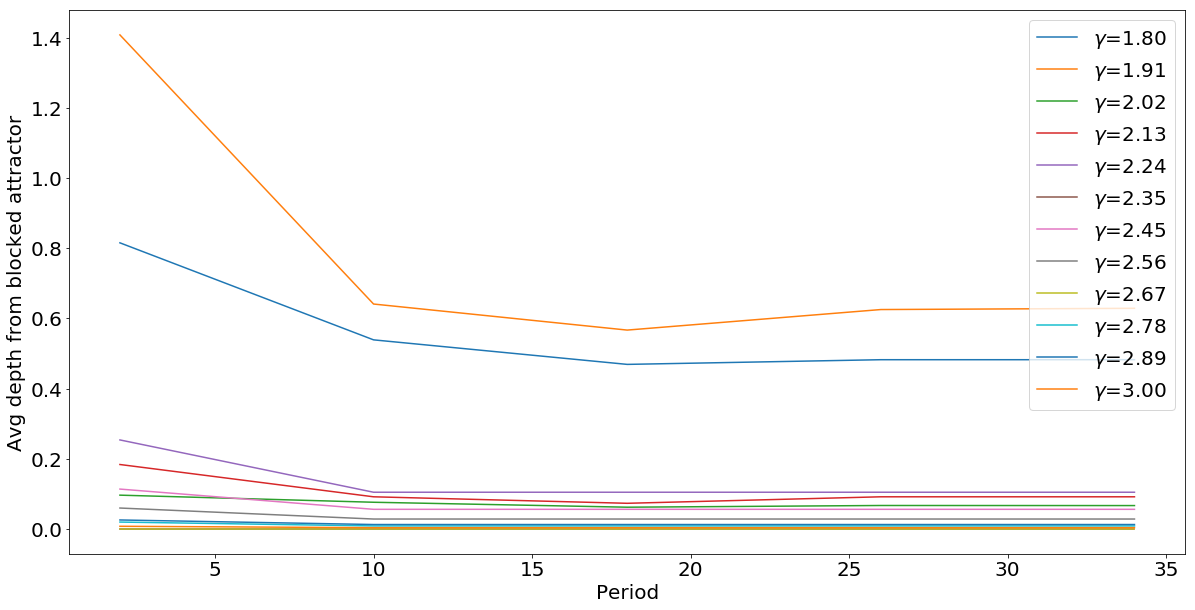

In [11]:
# gammas 
plt.plot(gammas, [np.mean(results_dict[gam]['blocked_ctrl']) for gam in gammas])
plt.xlabel(r"$\gamma$")
plt.ylabel("Number attractors")
# plt.title("Blocked Hub Node, N = 1000, r = 5")
plt.show()

for gamma in results_dict.keys():
    plt.plot(periods, [np.mean(results_dict[gamma][str(per)]['avg_number']) / 100.0 
                       for per in periods], label=r"$\gamma$=%.2f" %gamma)
   
plt.xlabel("Period")
plt.ylabel("Unique attractors / random starts")
# plt.title("Num attractors by period")
plt.legend()
plt.show()


for gamma in results_dict.keys():
    plt.plot(periods, [np.mean(results_dict[gamma][str(per)]['avg_depth']) 
                       for per in periods], label=r"$\gamma$=%.2f" %gamma)
   
plt.xlabel("Period")
plt.ylabel("Avg depth from blocked attractor")
# plt.title("Depth attractors by period")
plt.legend()
plt.show()





## Odyssey Data Analysis

### File IO

In [4]:
directory = "/Users/Sam/Documents/Harvard/Research/Results/Oscillating/Oscillating Attractors/Quantitative/N1000/OdysseyStatisticsAnalysis/"
file_1 = "attr_stats_01-09-23-27-00.csv"
file_2 = "attr_stats_updated_01-13.csv"
my_file = directory + file_2

In [5]:
df = pd.read_csv(my_file, index_col = 0)

### EDA

In [6]:
df.columns

Index(['avg_depth', 'avg_number', 'avg_overlap_with_block', 'avg_size',
       'gamma', 'hub_out', 'n', 'period', 'trials'],
      dtype='object')

In [7]:
groupby_cols = ["gamma", "period"]

In [8]:
# df.groupby(groupby_cols).mean()

In [9]:
# Manipulations
consolidated_df = df.groupby(groupby_cols).mean().sort_index(level=1, ascending=False).reset_index()

consolidated_df = consolidated_df.rename(index=str, 
                                         columns={"gamma": "$\gamma$", "period": "T", "avg_depth" : "Potential"})
consolidated_df['avg_number'] /= consolidated_df['trials']
# consolidated_df = consolidated_df.sort_values("T", ascending=True).sort_values("$\gamma$", ascending=True)#.reset_index(drop=True)

#### Attractor Landscape Density

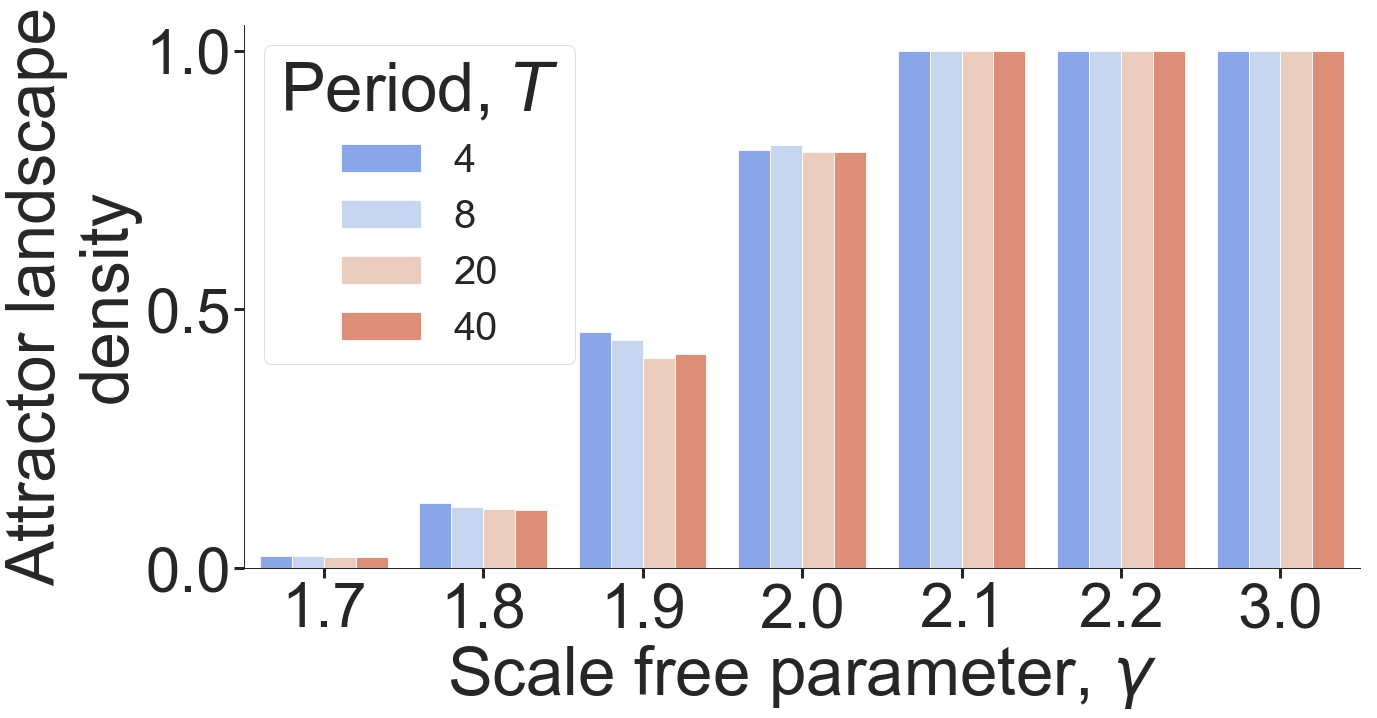

In [10]:
colors =  cols = sns.color_palette("coolwarm", 4) #plt.cm.jet(np.linspace(0,1,4))


# Turn this into a barplot... 
# indices = np.logical_or(df["$\gamma$"] < 2.2, df["$\gamma$"] >2.9)
# indices_2 = np.logical_and(indices, np.logical_or(df["T"] == 2, df["T"] == 34))


temp_mask = np.logical_and(consolidated_df["T"] != "blocked_ctrl", consolidated_df["T"] != "free_ctrl")
# temp_mask = np.logical_and(temp_mask, consolidated_df["T"] != "free_ctrl")


temp_df = consolidated_df[temp_mask]
temp_df = temp_df.astype({"T": "int32"})

### Note: we are artifically adding a little bit of space to the first bar... 
temp_df.loc[temp_df['$\gamma$'] == 1.7, 'avg_number'] += 0.02
sns.barplot(x="$\gamma$", hue="T",y="avg_number", data=temp_df, palette= colors)
plt.ylabel("Attractor landscape\ndensity")
plt.xlabel("Scale free parameter, $\gamma$")



plt.legend(title="Period, $T$", loc=2, fontsize=40)
sns.despine()
plt.savefig("/Users/Sam/Desktop/density.pdf", bbox_inches="tight")
plt.show()

#### Attractor Potential

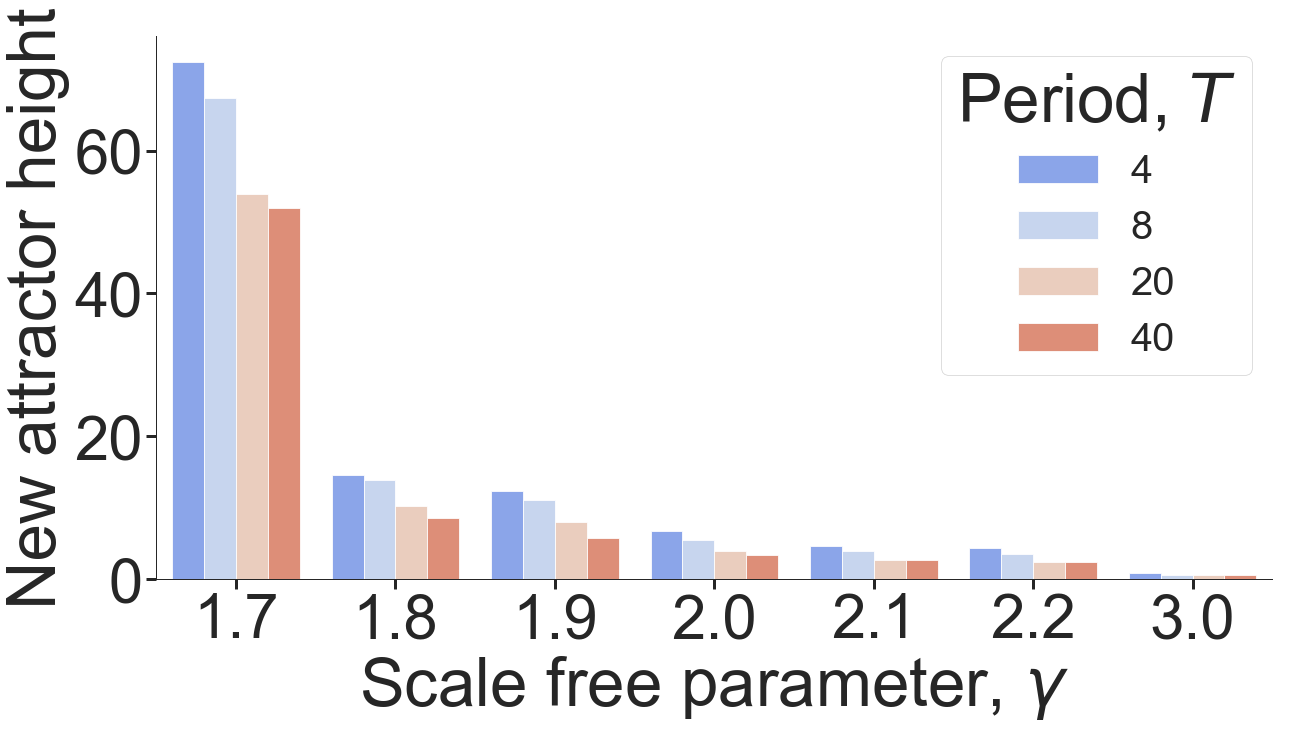

In [11]:

colors =  cols = sns.color_palette("coolwarm", 4) #plt.cm.jet(np.linspace(0,1,4))


sns.barplot(x="$\gamma$", hue="T",y="Potential", data=temp_df, palette= colors)
plt.legend(title="Period, $T$", fontsize=40)

plt.xlabel("Scale free parameter, $\gamma$")
plt.ylabel("New attractor height")


sns.despine()
plt.savefig("/Users/Sam/Desktop/height.pdf",bbox_inches="tight")
plt.show()

#### Attractor Cycle Size

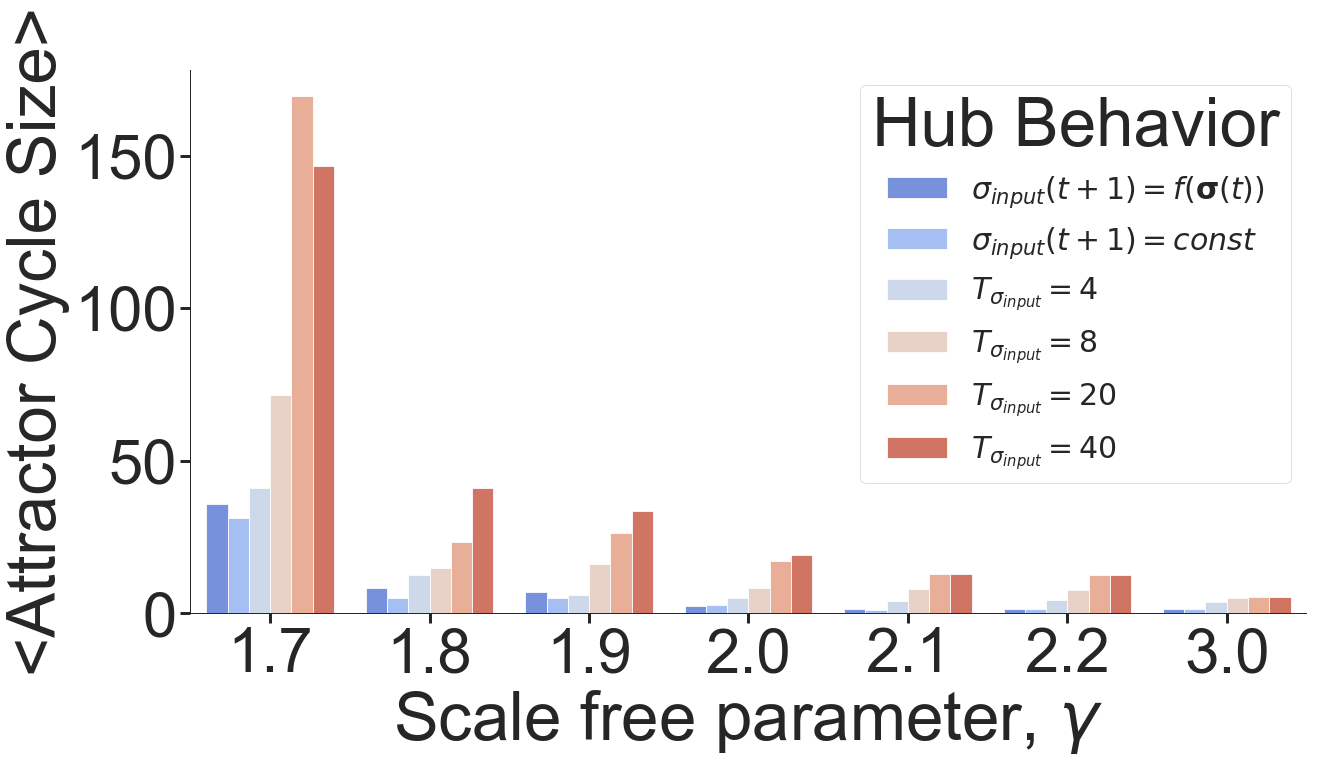

In [12]:
colors =  cols = sns.color_palette("coolwarm", 6) #plt.cm.jet(np.linspace(0,1,4))



temp_df = consolidated_df.copy()

temp_df.loc[temp_df["T"] == "free_ctrl", "T"] = "$\sigma_{input}(t+1) = f(\mathbf{\sigma}(t))$"
temp_df.loc[temp_df["T"] == "blocked_ctrl", "T"] = "$\sigma_{input}(t+1) = const$"
temp_df.loc[temp_df["T"] == "4", "T"] = "$T_{\sigma_{input}} = 4$"
temp_df.loc[temp_df["T"] == "8", "T"] = "$T_{\sigma_{input}} = 8$"
temp_df.loc[temp_df["T"] == "20", "T"] = "$T_{\sigma_{input}} = 20$"
temp_df.loc[temp_df["T"] == "40", "T"] = "$T_{\sigma_{input}} = 40$"


order = ["$\sigma_{input}(t+1) = f(\mathbf{\sigma}(t))$", 
         "$\sigma_{input}(t+1) = const$", 
         "$T_{\sigma_{input}} = 4$", "$T_{\sigma_{input}} = 8$", 
        "$T_{\sigma_{input}} = 20$", "$T_{\sigma_{input}} = 40$"] 




sns.barplot(x="$\gamma$", hue="T",y="avg_size", data=temp_df, hue_order=order, palette=colors)
plt.ylabel("<Attractor Cycle Size>")
plt.legend(title="Hub Behavior", fontsize=30)
plt.xlabel("Scale free parameter, $\gamma$")
sns.despine()
plt.savefig("/Users/Sam/Desktop/attr_size.pdf",bbox_inches="tight")
plt.show()

#### Attractor Landscape Density Non periodic

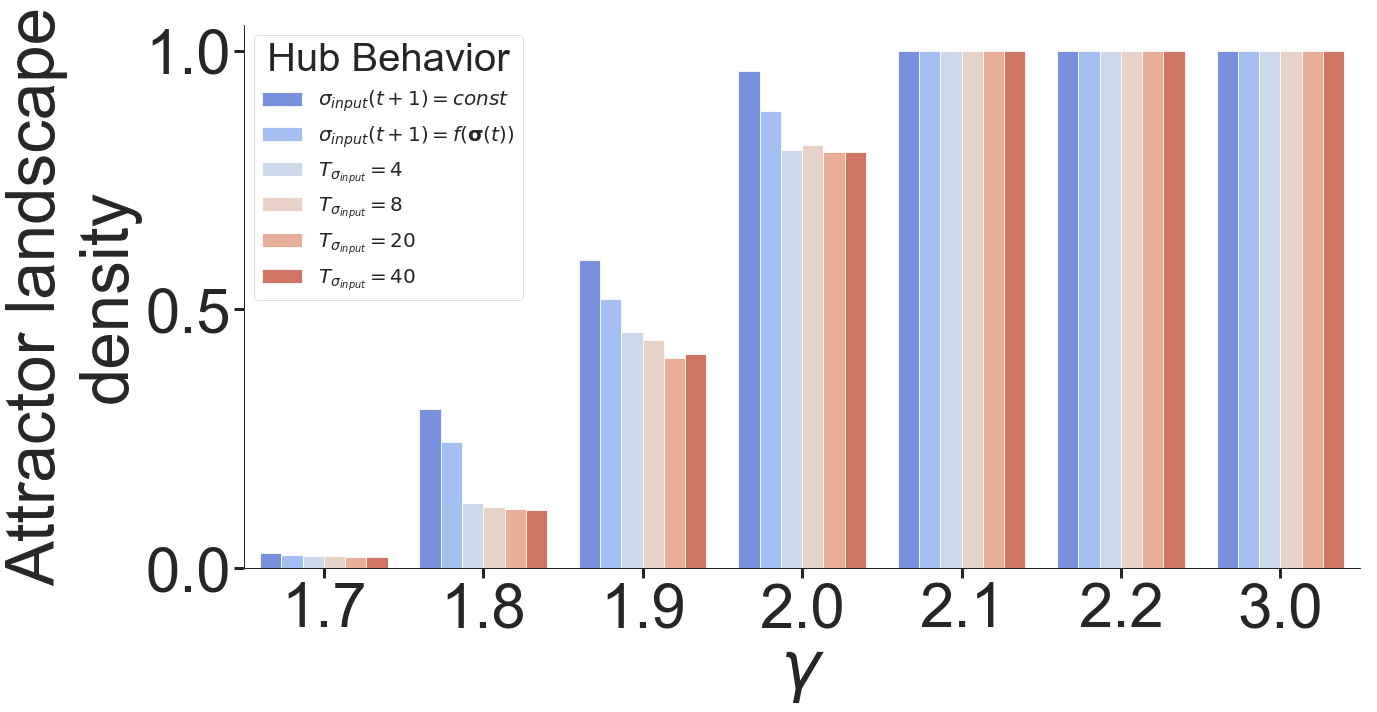

In [13]:

colors =  cols = sns.color_palette("coolwarm", 6) #plt.cm.jet(np.linspace(0,1,4))




temp_mask = np.logical_or(consolidated_df["T"] == "free_ctrl", consolidated_df["T"] == "blocked_ctrl")
temp_df = consolidated_df.copy()#[temp_mask].copy()

temp_df.loc[temp_df["T"] == "4", "T"] = "$T_{\sigma_{input}} = 4$"
temp_df.loc[temp_df["T"] == "8", "T"] = "$T_{\sigma_{input}} = 8$"
temp_df.loc[temp_df["T"] == "20", "T"] = "$T_{\sigma_{input}} = 20$"
temp_df.loc[temp_df["T"] == "40", "T"] = "$T_{\sigma_{input}} = 40$"



order = [
         "$\sigma_{input}(t+1) = const$","$\sigma_{input}(t+1) = f(\mathbf{\sigma}(t))$", 
         "$T_{\sigma_{input}} = 4$", "$T_{\sigma_{input}} = 8$", 
        "$T_{\sigma_{input}} = 20$", "$T_{\sigma_{input}} = 40$"] 



temp_df.loc[temp_df["T"] == "free_ctrl", "T"] = "$\sigma_{input}(t+1) = f(\mathbf{\sigma}(t))$"
temp_df.loc[temp_df["T"] == "blocked_ctrl", "T"] = "$\sigma_{input}(t+1) = const$"

### Note: we are artifically adding a little bit of space to the first bar... 
temp_df.loc[temp_df['$\gamma$'] == 1.7, 'avg_number'] += 0.02



sns.barplot(x="$\gamma$", hue="T",y="avg_number", data=temp_df, hue_order=order,palette=colors)
plt.ylabel("Attractor landscape\ndensity")
legend = plt.legend(title="Hub Behavior", fontsize=20, loc=2)
legend.get_title().set_fontsize('40') 

sns.despine()
plt.savefig("/Users/Sam/Desktop/sup_density.pdf",bbox_inches="tight")
plt.show()

#### Number of blocked attr overlap...

In [15]:
consolidated_df.columns

Index(['$\gamma$', 'T', 'Potential', 'avg_number', 'avg_overlap_with_block',
       'avg_size', 'hub_out', 'n', 'trials'],
      dtype='object')

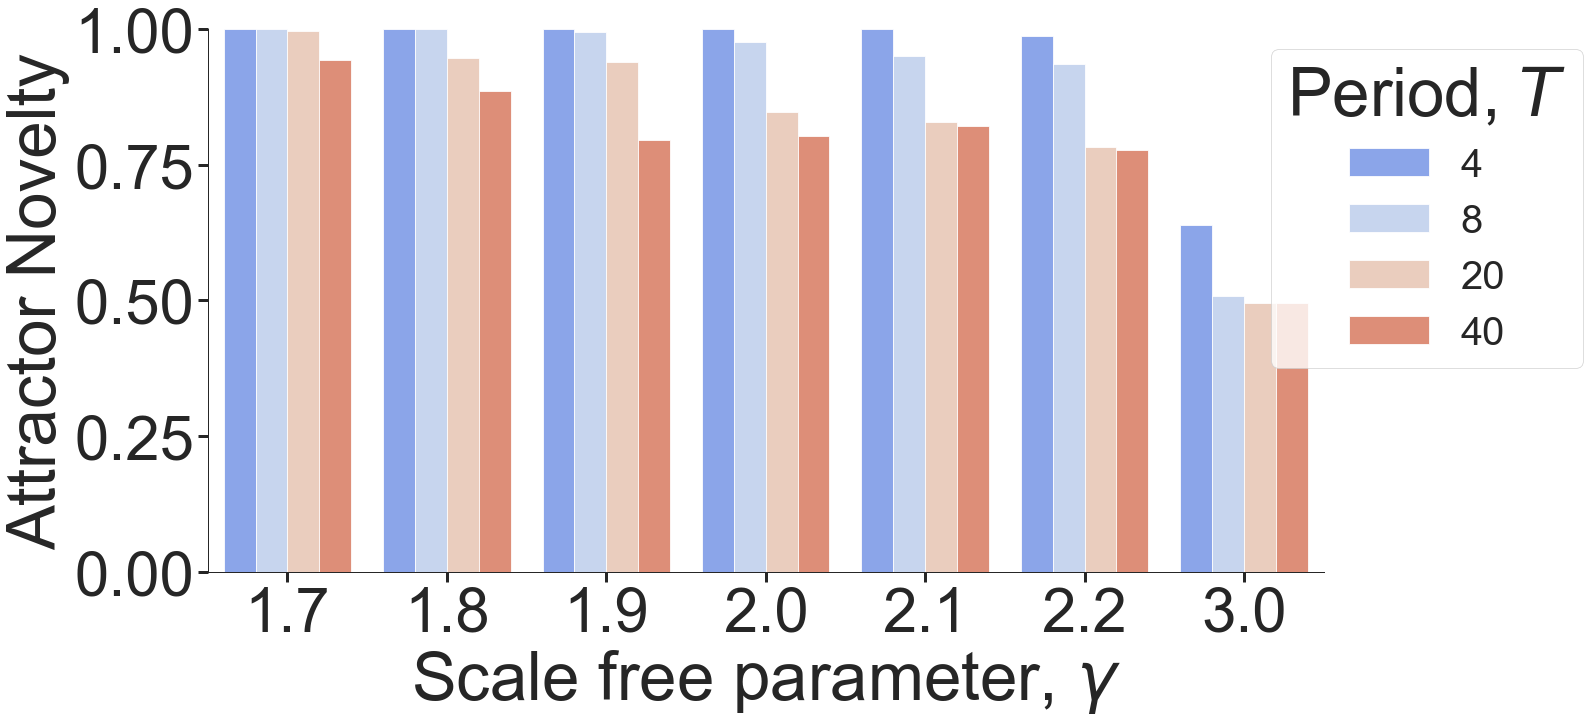

In [16]:

colors =  cols = sns.color_palette("coolwarm", 4) #plt.cm.jet(np.linspace(0,1,4))


# Turn this into a barplot... 
# Show the fraction overlapping with the null
temp_mask = np.logical_and(consolidated_df["T"] != "blocked_ctrl", consolidated_df["T"] != "free_ctrl")


temp_df = consolidated_df[temp_mask]
temp_df = temp_df.astype({"T": "int32"})
temp_df["avg_overlap_with_block"] = 1 - temp_df["avg_overlap_with_block"] 


sns.barplot(x="$\gamma$", hue="T",y="avg_overlap_with_block", data=temp_df,  palette = colors)
plt.ylabel("Attractor Novelty")
plt.xlabel("Scale free parameter, $\gamma$")

plt.ylim([0,1])

legend = plt.legend(title="Period, $T$", fontsize=40, bbox_to_anchor=(1.25, 1))
# legend.get_title().set_fontsize('70') 
sns.despine()
plt.savefig("/Users/Sam/Desktop/frac_overlap.pdf",bbox_inches="tight")
plt.show()